<h1>Linear  Classifier with PyTorch with Transfer Learning </h1>


<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab:


In [ ]:
!pip install skillsnetwork


from PIL import Image
import matplotlib.pyplot as plt
import os
os.makedirs('/resources/data', exist_ok=True)
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim
import skillsnetwork
import numpy as np  # Import numpy
import matplotlib.pyplot as plt
import torchvision.models as models


<h2 id="download_data">Download Data</h2>


In this section, you are going to download the data from IBM object storage using **skillsnetwork.prepare** command. <b>skillsnetwork.prepare</b> is a command that's used to download a zip file, unzip it and store it in a specified directory. Locally we store the data in the directory  **/resources/data**.


First, we download the file that contains the images:


In [ ]:
await skillsnetwork.prepare("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip", path = "/resources/data", overwrite=True)

  0%|          | 0/40000 [00:00<?, ?it/s]

Saved to '../resources/data'


<h2 id="data_class">Dataset Class</h2>


In this section, we will use the previous code to build a dataset class. As before, make sure the even samples are positive, and the odd samples are negative.  In this case, if the parameter <code>train</code> is set to <code>True</code>, use the first 10 000 samples as training data; otherwise, the last 10 000 samples will be used as validation data. Do not forget to sort your files so they are in the same order.  


**Note:** We are using the first 10,000 samples as our training data instead of the available 30,000 to decrease the training time of the model. If you want, you can train it yourself with all 30,000 samples just by modifying 2 lines in the following code chunk.


In [ ]:
class ConcreteDataset(Dataset):
    def __init__(self, directory, transform=None, train=True):
        positive = "Positive"
        negative = "Negative"

        positive_file_path = os.path.join(directory, positive)
        negative_file_path = os.path.join(directory, negative)
        positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files = [os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples = len(positive_files) + len(negative_files)
        self.all_files = [None] * number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files

        self.transform = transform
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1
        self.Y[1::2] = 0

        if train:
            self.all_files = self.all_files[:10000]
            self.Y = self.Y[:10000]
        else:
            self.all_files = self.all_files[10000:20000]
            self.Y = self.Y[10000:20000]

        self.len = len(self.all_files)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        image = Image.open(self.all_files[idx])
        y = self.Y[idx]

        if self.transform:
            image = self.transform(image)

        return image, y


<h2 id="trasform_Data_object">Transform Object and Dataset Object</h2>


Create a transform object, that uses the <code>Compose</code> function. First use the transform <code>ToTensor()</code> and followed by <code>Normalize(mean, std)</code>. The value for <code> mean</code> and <code>std</code> are provided for you.


In [ ]:
# Create transform object
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean, std)])

Create object for the training data  <code>dataset_train</code> and validation <code>dataset_val</code>. Use the transform object to convert the images to tensors using the transform object:


In [ ]:
train_dataset = ConcreteDataset('/resources/data', transform=transform, train=True)
val_dataset = ConcreteDataset('/resources/data', transform=transform, train=False)

train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

In [ ]:
# Model Setup
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.003)


In [ ]:
# Training Loop
num_epochs = 20
train_loss_list = []
val_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    loss_sublist = []
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss_sublist.append(loss.item())
        loss.backward()
        optimizer.step()
    train_loss_list.append(np.mean(loss_sublist))

    model.eval()
    correct = 0
    total = 0
    misclassified_samples = []
    with torch.no_grad():
        for x_test, y_test in val_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            outputs = model(x_test)
            _, predicted = torch.max(outputs.data, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
            for i in range(y_test.size(0)):
                if predicted[i] != y_test[i]:
                    misclassified_samples.append((x_test[i].cpu(), predicted[i].cpu(), y_test[i].cpu()))

    accuracy = 100 * correct / total
    val_accuracy_list.append(accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss_list[-1]:.4f}, Validation Accuracy: {accuracy:.2f}%')


Epoch 1/20, Loss: 0.1076, Validation Accuracy: 99.34%
Epoch 2/20, Loss: 0.0644, Validation Accuracy: 99.44%
Epoch 3/20, Loss: 0.0772, Validation Accuracy: 99.52%
Epoch 4/20, Loss: 0.0677, Validation Accuracy: 99.41%
Epoch 5/20, Loss: 0.0741, Validation Accuracy: 99.62%
Epoch 6/20, Loss: 0.0477, Validation Accuracy: 99.64%
Epoch 7/20, Loss: 0.0658, Validation Accuracy: 99.56%
Epoch 8/20, Loss: 0.0953, Validation Accuracy: 99.56%
Epoch 9/20, Loss: 0.0772, Validation Accuracy: 98.69%
Epoch 10/20, Loss: 0.0551, Validation Accuracy: 99.62%
Epoch 11/20, Loss: 0.0442, Validation Accuracy: 99.63%
Epoch 12/20, Loss: 0.0596, Validation Accuracy: 99.51%
Epoch 13/20, Loss: 0.0568, Validation Accuracy: 99.50%
Epoch 14/20, Loss: 0.0769, Validation Accuracy: 99.37%
Epoch 15/20, Loss: 0.0733, Validation Accuracy: 99.67%
Epoch 16/20, Loss: 0.0712, Validation Accuracy: 99.61%
Epoch 17/20, Loss: 0.0801, Validation Accuracy: 98.96%
Epoch 18/20, Loss: 0.0525, Validation Accuracy: 99.48%
Epoch 19/20, Loss: 

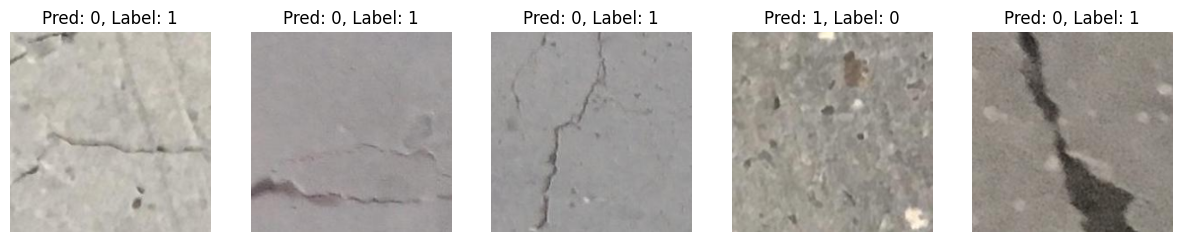

In [ ]:
# Plot Misclassified Samples
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (img, pred, label) in enumerate(misclassified_samples[:5]):
    img = img.permute(1, 2, 0)
    img = img * torch.tensor(std).view(1, 1, 3) + torch.tensor(mean).view(1, 1, 3)
    img = img.numpy()
    axes[i].imshow(img)
    axes[i].set_title(f'Pred: {pred.item()}, Label: {label.item()}')
    axes[i].axis('off')
plt.show()

In [ ]:
print("Misclassified Samples:")
for i, (img, pred, label) in enumerate(misclassified_samples[:4]):
    print(f"Sample {i+1} predicted value: {pred}, actual value: {label}")

Misclassified Samples:
Sample 1 predicted value: 0, actual value: 1
Sample 2 predicted value: 0, actual value: 1
Sample 3 predicted value: 0, actual value: 1
Sample 4 predicted value: 1, actual value: 0


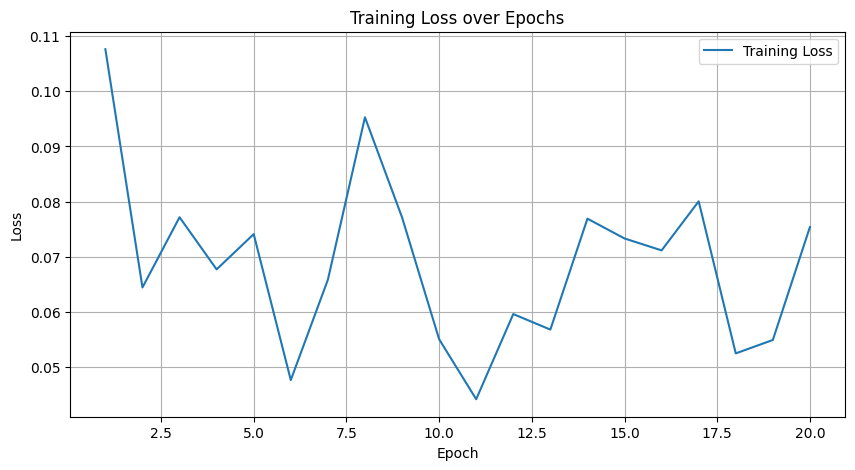

In [ ]:
# Plot the Training Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

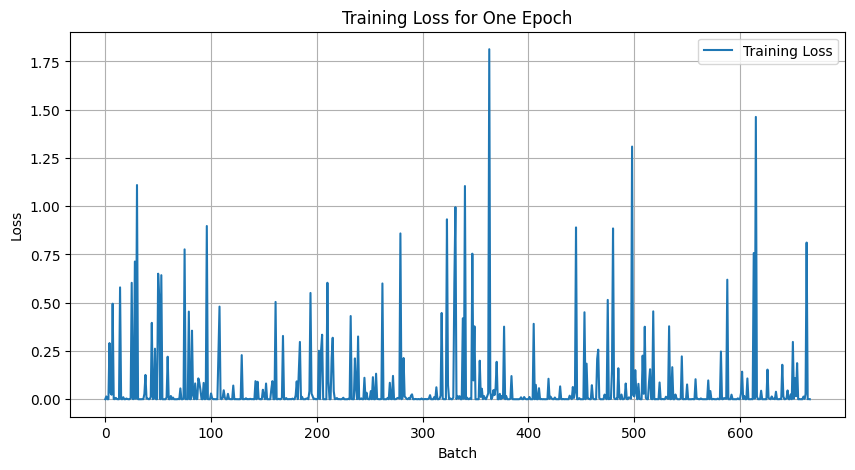

In [ ]:
import matplotlib.pyplot as plt

# Training Loop for One Epoch
model.train()
train_loss_list = []
for x, y in train_loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    train_loss_list.append(loss.item())

# Plot the Training Loss for One Epoch
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_loss_list)), train_loss_list, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss for One Epoch')
plt.legend()
plt.grid(True)
plt.show()
